In [1]:
from CHECLabPy.core.io import DL1Reader, HDF5Writer
from CHECLabPy.utils.files import sort_file_list
import numpy as np
from numpy.polynomial.polynomial import polyfit, polyval
import pandas as pd
from os.path import join
from glob import glob
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [73]:
directory_0mhz = "/Volumes/gct-jason/data_checs/d181010_dynrange_sm/0MHz/100mV/selfped"
directory_40mhz = "/Volumes/gct-jason/data_checs/d181010_dynrange_sm/40MHz/100mV/selfped"

In [74]:
def read_runlist(path):
    return pd.read_csv(path, delimiter=' ', index_col=0, comment='#')

runlist_0mhz = read_runlist(join(directory_0mhz, "runlist.txt"))
runlist_40mhz = read_runlist(join(directory_40mhz, "runlist.txt"))

In [75]:
def get_dl1_path_list(directory):
    return sort_file_list(glob(join(directory, "*_dl1.h5")))

dl1_paths_0mhz = get_dl1_path_list(directory_0mhz)
dl1_paths_40mhz = get_dl1_path_list(directory_40mhz)

In [76]:
dl1_paths_spe = dl1_paths_0mhz[-8:-3]

In [77]:
def extract_charge_df(dl1_paths, runlist):
    df_list = []
    for path in dl1_paths:
        regex = re.search(r".*Run(\d+)_dl1.h5", path)
        run = int(regex.group(1))
        illumination = runlist.loc[run, 'pe_expected']
        with DL1Reader(path) as reader:
            dl1_df = reader.read('data')

        dl1_df = dl1_df[['iev', 'pixel', 'charge']] # Select columns
        dl1_df['estimated_illumination_pe'] = illumination
        df_list.append(dl1_df)
    df = pd.concat(df_list, ignore_index=True)
    return df

In [78]:
%%capture
df_spe = extract_charge_df(dl1_paths_spe, runlist_0mhz)
df_40mhz = extract_charge_df(dl1_paths_40mhz, runlist_40mhz)

In [94]:
poi = 35

def select_pixel(df, poi):
    return df.loc[df['pixel'] == poi]

df_spe_poi = select_pixel(df_spe, poi)
df_40mhz_poi = select_pixel(df_40mhz, poi)

In [95]:
# Rough Charge Calibration
def calculate_calib(df):
    est_ill = df['estimated_illumination_pe']
    index = (est_ill < 1e2)
    df_calib = df.loc[index]

    illumination = df_calib['estimated_illumination_pe']
    charge = df_calib['charge']
    c = polyfit(illumination, charge, 1)

    plt.plot(illumination, charge, '.')
    plt.plot(illumination, polyval(illumination, c))
    
    return c

def calibrate_charge(df, c):    
    df = df.copy()
    df['charge'] = (df['charge'] - c[0]) / c[1]
    return df

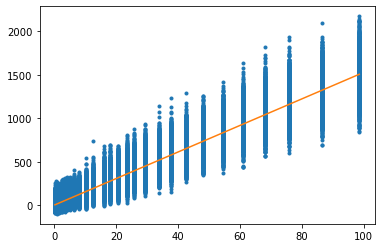

In [96]:
c = calculate_calib(df_40mhz_poi)
df_spe_calibrated = calibrate_charge(df_spe_poi, c)
df_40mhz_calibrated = calibrate_charge(df_40mhz_poi, c)

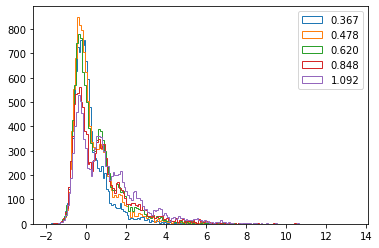

In [97]:
# Plot SPE
for illumination, group in df_spe_calibrated.groupby('estimated_illumination_pe'):
    label = f"{illumination:.3f}"
    _ = plt.hist(group['charge'], bins=150, histtype='step', label=label)
plt.legend()

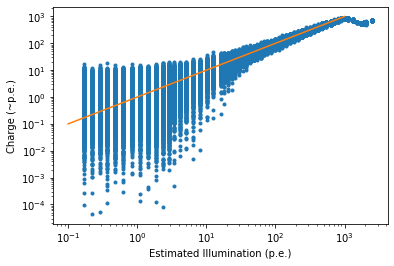

In [98]:
# Plot Dynamic Range
plt.plot(df_40mhz_calibrated['estimated_illumination_pe'], df_40mhz_calibrated['charge'], '.')
plt.plot(np.geomspace(0.1, 1000), np.geomspace(0.1, 1000))
plt.xlabel("Estimated Illumination (p.e.)")
plt.ylabel("Charge (~p.e.)")
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0, 1000])

In [99]:
# Save to disk
with HDF5Writer("charge_lab.h5") as writer:
    writer.write(spe=df_spe_calibrated)
    writer.write(nsb40mhz=df_40mhz_calibrated)
    writer.add_metadata(
        poi=poi,
        dl1_paths_spe=dl1_paths_spe,
        dl1_paths_40mhz=dl1_paths_40mhz,
    )

Creating HDF5 file: charge_lab.h5
Saving metadata to HDF5 file


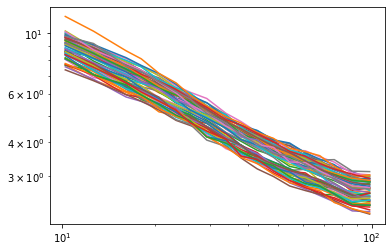

In [100]:
mean = np.zeros(64)
for poi in range(64):
    df_poi = select_pixel(df_40mhz, poi)
    df_poi = df_poi.loc[(df_poi['estimated_illumination_pe'] > 1e1) & (df_poi['estimated_illumination_pe'] < 1e2)]
    calibrate_charge(df_poi, c)
    df_std = df_poi.groupby('estimated_illumination_pe').std()
    plt.plot(df_std.index, df_std['charge']/df_std.index, label=poi)
    mean[poi] = (df_std['charge']/df_std.index).mean()
    #print(df_std)
plt.xscale('log')
plt.yscale('log')

In [101]:
mean.argmax()

31